In [1]:
# pip install opencv-contrib-python==3.4.2.17

In [2]:
import helper, sys, math, sklearn, cv2
from skimage import color
from skimage.util import img_as_float,  img_as_ubyte                                       
from skimage.segmentation import slic, mark_boundaries
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing, svm, metrics
import numpy as np
from sklearn.model_selection import train_test_split


# **Αναπαράσταση Εικόνας στον Χρωματικό Χώρο Lab**

-----img_rgb info-----
Τύπος μεταβλητής: <class 'numpy.ndarray'> 
Διαστάσεις: (600, 800, 3) 

-----img_lab info-----
Τύπος μεταβλητής: <class 'numpy.ndarray'> 
Διαστάσεις: (600, 800, 3) 



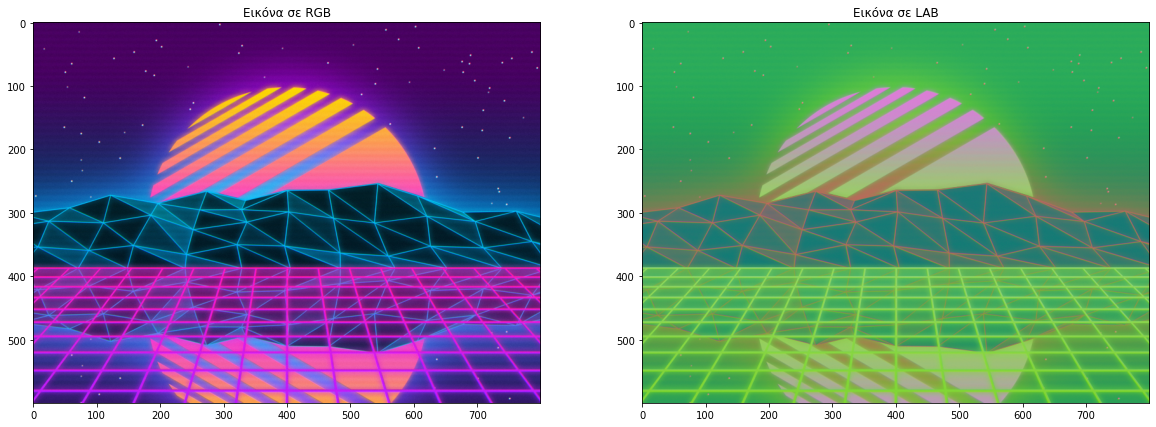

In [3]:
# φορ΄τωνουμε την εικόνα σε μια μεταβλητή
img = cv2.imread("image2.jpg")

# η open cv διαβάζει τις εικονες σε bgr, για αυτό την μετατρέπουμε σε rgb
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"-----img_rgb info-----\nΤύπος μεταβλητής: {type(img_rgb)} \n" 
      f"Διαστάσεις: {img_rgb.shape} \n")

# μετατροπή εικόνας σε lab
img_lab = helper.rgb2lab(img_rgb)
print(f"-----img_lab info-----\nΤύπος μεταβλητής: {type(img_lab)} \n" 
      f"Διαστάσεις: {img_lab.shape} \n")

# προβολή εικόνων
helper.subplot_in_row_images(images=[img_rgb, img_lab], titles=["Εικόνα σε RGB", "Εικόνα σε LAB"])


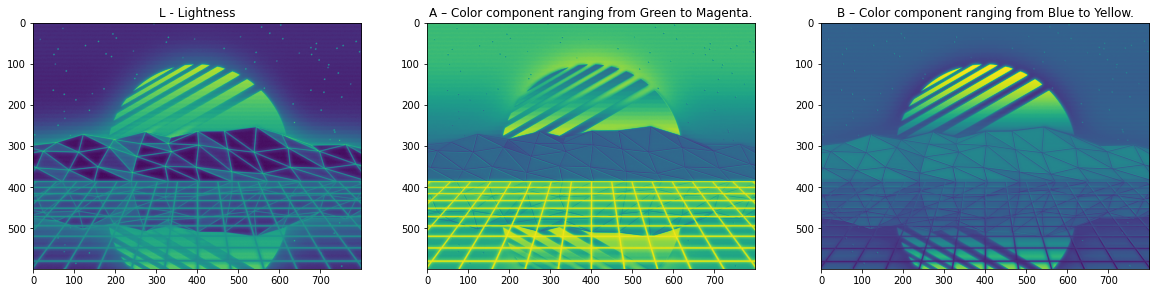

In [4]:
# αποθηκεύω κάθε ξεχωριστό κανάλι της εικόνας lab σε διαφορετική μεταβλητή
l, a, b = cv2.split(img_lab)
# εμφάνιση των καναλιών
helper.subplot_in_row_images(images=[l,a,b], titles=['L - Lightness','A – Color component ranging from Green to Magenta.',
                                                     'B – Color component ranging from Blue to Yellow.'])

# **Διακριτοποίηση του Χρωματικού Χώρου Lab με βάση ένα σύνολο συναφών εικόνων εκπαίδευσης**

In [5]:
def quintize_image(image_lab):
    """
    Συνάρτηση που δέχεται σαν όρισμα μια εικόνα LAB 
    και επιστρέφει την κβαντισμένη εκδοχή της μαζί με τα
    κεντροειδή της.
    """
    # απο την εικόνα lab αποθηκεύουμε τις διαστάσεις σε αντίστοιχες μεταβλητές
    height, width, depth = img_lab.shape

    # την κάνουμε reshape για να μπορέσουμε να την δώσουμε στον k-mean αλγόριθμο
    reshaped_img_lab = img_lab.reshape((height * width, depth))

    # αρχικοποιούμε τον mini batch k mean αλγόριθμο 
    # με έναν προτεινόμενο αριθμό για clusters
    k_means = MiniBatchKMeans(n_clusters = 32)

    # κάνουμε fit τον αλγόριθμο πάνω στην reshape lab εικόνα
    k_means.fit(reshaped_img_lab)
    
    # βρίσκουμε τις κεντροειδή συντεταγμενες της εικόνας
    # και τις μετατρέπουμε σε ακέραιους αριθμούς
    centroids = k_means.cluster_centers_.astype("uint8")

    # ανασχηματίζουμε την εικόνα που κάναμε reshape
    pixel_labels = k_means.predict(reshaped_img_lab)
    img_lab_q = centroids[pixel_labels]
    img_lab_q = img_lab_q.reshape((height, width, depth))
    
    return img_lab_q, centroids, k_means

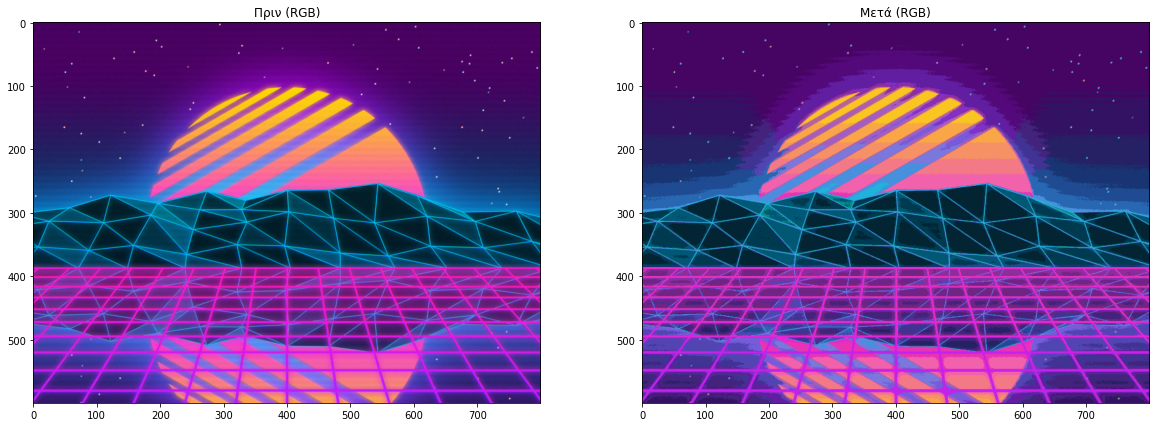

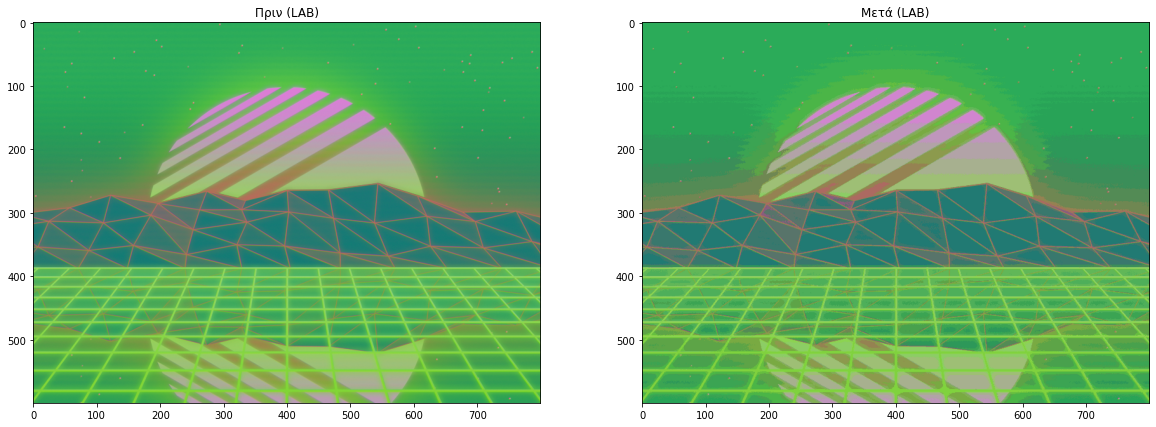

In [6]:
img_lab_q, centroids, k_means = quintize_image(img_lab)

# εμφανίζουμε την κβαντισμένη εικόνα σε rgb και lab μαζί με την αρχική
helper.subplot_in_row_images(images=[img_rgb, helper.lab2rgb(img_lab_q)], 
                             titles=["Πριν (RGB)", "Μετά (RGB)"])

helper.subplot_in_row_images(images=[img_lab, img_lab_q], 
                             titles=["Πριν (LAB)", "Μετά (LAB)"])

#   **Κατάτμηση Εικόνας σε Superpixels σύμφωνα με τον αλγόριθμο SLIC.**

In [7]:
def slic_image(image):
    """
    Δέχεται σαν όρισμα την κβαντισμένη εικόνα,
    αυτό που επιστρέφει είναι μια λίστα με τα superpixel και 
    την 'τεμαχισμένη' εικόνα
    """
    # βρίσκουμε τα όρια για κάθε superpixel στην εικόνα
    groups = slic(image=img_as_float(image), n_segments=100, compactness=10, sigma=1)
    group_ids = np.unique(groups)
    
    
    slic_centroids = []
    slic_centroids.append(np.array([np.mean(np.nonzero(groups == i), axis=1) for i in group_ids]))
    
    # θα κάνουμε loop πάνω σε όλα τα superpixel και θα τα κάνουμε extract
    # χρησιμοποιώντας μάσκα
    superpixels = []
    
    for group in group_ids:
        mask = np.zeros(image.shape[:2], dtype="uint8")
        mask[groups == group] = 255

        # Δημιουργούμε μια είκονα με το μαρκαρισμένο superpixel
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        superpixels.append(masked_image)
    
    # Δημιουργούμε μία εικόνα που περιέχει όλα τα σημειωμένα superpixel
    marked_image = mark_boundaries(image, groups)
    marked_image = img_as_ubyte(marked_image)
    
    return superpixels, slic_centroids, marked_image

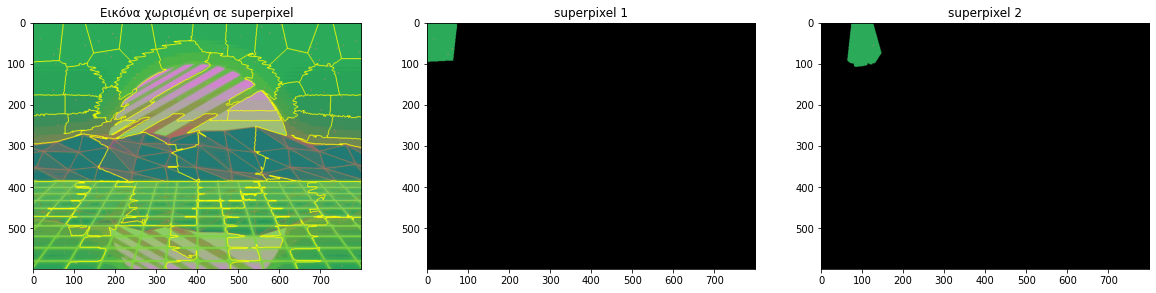

In [8]:
# εφαρμόζουμε τον slic αλγόριθμο σην rgb εικόνα και παίρνουμε την λίστα με τα superpixels
superpixels, slic_centroids, marked_image = slic_image(img_lab_q)

# εμφανίζουμε την 'τεμαχισμένη' εικόνα και κάποια superpixel
helper.subplot_in_row_images(images = [marked_image, superpixels[0], superpixels[1]],
                             titles = ["Εικόνα χωρισμένη σε superpixel", "superpixel 1", "superpixel 2"]
                            )

# **Εξαγωγή Χαρακτηριστικών Υφής (SURF Features & Gabor Features) ανά Super Pixel.**

In [9]:
def compute_surf(superpixels):
    """
    Συνάρτηση που δέχεται σαν όρισμα την λίστα με τα superpixel μιας εικόνας
    και επιστρέφει τα descriptors, τα keypoints, και για κάθε superpixel την 
    μαρκαρισμένη εικόνα.
    """
    
    # Δημιουργούμε ένα αντικείμενο surf και ενεργοποιούμε το extended mode
    surf = cv2.xfeatures2d.SURF_create()
    surf.setExtended(True)
    
    # αρχικοποιούμε τις λ΄ίστες
    keypoints_list = []
    descriptors_list = []
    mark_superpixel = []

    # κάνουμε loop πάνω στα superpixel
    for superpixel in superpixels:
        # αποθηκεύουμε τα keypoins και τα descriptors
        keypoints, descriptors = surf.detectAndCompute(superpixel, None)

        # μαρκάρουμε τα keypoints πάνω στο superpixel
        surf_img = cv2.drawKeypoints(superpixel, keypoints, None, (255, 0, 0), 4)
        
        # τα αποθηκεύουμε όλα σε ΄΄λίστες
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)
        mark_superpixel.append(surf_img)
    
    return keypoints_list, descriptors_list, mark_superpixel

51
51


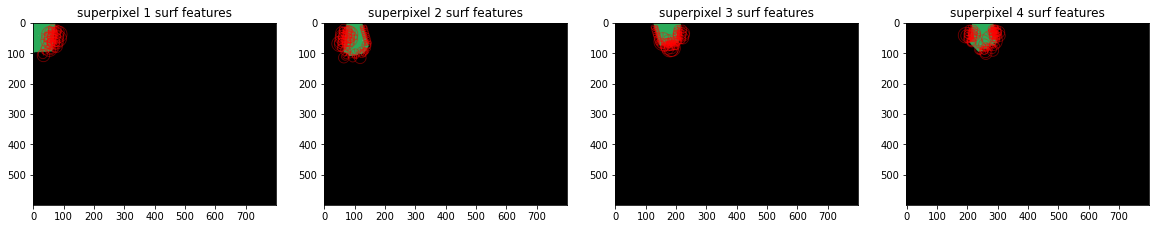

In [10]:
img_surf_keypoints, img_surf_descriptors, img_surf_mark_superpixels = compute_surf(superpixels)

print(len(superpixels))
print(len(img_surf_descriptors))
# εμφανίζουμε τα πρώτα y μαρκαρισμένα superpixel
y = 4
helper.subplot_in_row_images(images=[img_surf_mark_superpixels[i] for i in range(y)], 
                             titles=[f"superpixel {i + 1} surf features" for i in range(y)])

In [11]:
def build_kernels():
    """
    Συνάρτηση που δημιουργεί και επιστρέφει τα gabor kernels
    """
    # αρχικοποίηση
    gabor_kernels = []
    for theta in (np.arange(0, np.pi, np.pi / 16)):
        # Δημιουργούμε 16 gabor kernel με διαφορετικο προσανατολισμό
        kernel = cv2.getGaborKernel((31, 31), 4.0, theta, 10.0, 0.5, 0.0, cv2.CV_32F)

        # το κανονικοποιούμε και το αποθηκεύουμε στην λίστα
        kernel /= 1.5 * kernel.sum()
        gabor_kernels.append(kernel)

    return gabor_kernels 

def apply_kernels(image):
    """
    Συνάρτηση που εφαρμόζει τα kernels και επιστρέφει όλα τα response απο τα kernel
    και μια λίστα με τα ξεχωριστά responses.
    """
    # Δημοιυργούμε μια response image που θα περιλαμβάνει όλες τις αντιδράσεις του kernel
    response = np.zeros_like(image)

    # Αρχικοποίηση της λίστας που θα αποθηκεύει ξεχωριστά κάθε response από κάθε kernel
    responses = []

    gabor_kernels = build_kernels()

    for kernel in gabor_kernels:
        # Δημιουργούμε ένα φίλτρο και το εφαρμόζουμε στην εικόνα
        filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)

        # Αποθηκεύουμε το ξεχωριστό respons
        responses.append(filtered)

        # Συνεχίζουμε να προσθέτουμε στην response εικόνα καθώς παιρνάμε από τα kernel
        np.maximum(response, filtered, response)

    return response, responses

def compute_gabor(superpixels):
    """
    Συνάρτηση που επιστρέφει τα gabor features και τις gabor εικόνες για κάθε superpixel
    """
    # Αρχικοποίηση
    gabor_features = []
    gabor_images = []
    
    for superpixel in superpixels:
        # Εφαρμόζουμε όλα τα gabor kernel στο superpixel
        gabor_img, responses = apply_kernels(superpixel)

        # Αποθηκέυουμε τα responses και την εικόνα του superpixel
        gabor_features.append(responses)
        gabor_images.append(gabor_img)
        
    return gabor_features, gabor_images

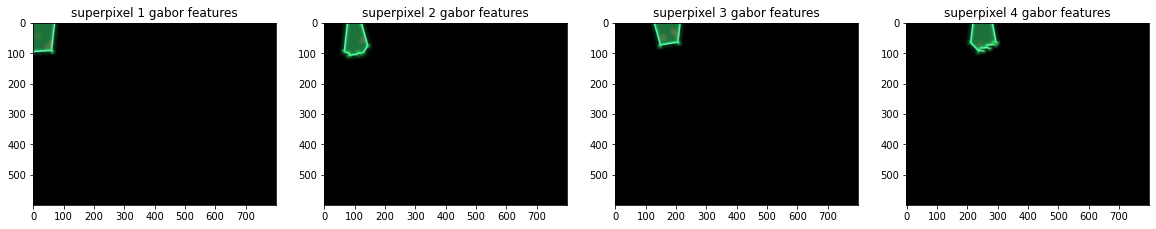

In [12]:
img_gabor_features, img_gabor_images = compute_gabor(superpixels)

# εμφανίζουμε τα y πρώτα superpixel
y = 4
helper.subplot_in_row_images(images=[img_gabor_images[i] for i in range(y)], 
                             titles=[f"superpixel {i + 1} gabor features" for i in range(y)])

# **Εκμάθηση Τοπικών Μοντέλων Πρόγνωσης Χρώματος με Χρήση Ταξινομητών SVM**

In [13]:
def make_dataset(superpixels, slic_centroids, surf_descriptors, gabor_features, colors_lab, k_means):
    """
    Συνάρτηση που δέχεται σαν όρισμα τα superpixel, τα slic κεντροειδή,
    τα surf descriptors, τα gabor features , τα κεντροειδή χρώματα lab και τον k mean αλγόριθμο
    Επιστρέφει το dataset για την εκπαίδευση του ταξινομητή
    """
    # από τα lab στοιχεία απομονώνοτμε τις AB τιμές για ΄όλα τα κβαντισμένα χρώματα
    colors_ab = colors_lab[:, 1:]
    
    colors_ab_idx = {}

    # κρατάμε τα lab σε ένα λεξικό για όλα τα κβαντισμένα χρώματα
    for idx, color in enumerate(colors_ab):
        colors_ab_idx[color[0], color[1]] = idx
        
    # θα υπολογσίσουμε τα lab χ΄ρώματα για κάθε superpixel
    centroid_colors = []

    for superpixel in superpixels:
        # βρίσκουμε όλα τα nonzero pixels μέσα στο superpixel
        x_s, y_s, _ = np.nonzero(superpixel)
        items = [superpixel[i, j, :] for i, j in zip(x_s, y_s)]
        items = np.array(items)

        # Calculate the mean of L, a, b values
        # υπολογίζουμε το mean από τις LAB τιμές
        avg_L = np.mean(items[:, 0])
        avg_a = np.mean(items[:, 1])
        avg_b = np.mean(items[:, 2])
        
        # κβαντίζουμε το mean χρώμα για κάθε superpixel χρησιμοποιώντας τον k_mean αλγόριθμο
        label = k_means.predict([[avg_L, avg_a, avg_b]])

        # αποθηκεύουμε τις a, b values για κάθε superpixel
        color = colors_lab[label, 1:]
        centroid_colors.append(color)

    surf_avg = []

    for surf in surf_descriptors:
        if surf is None:
            surf_avg.append(0)
            continue
        # υπολογίζουμε τις mean surf τιμές για κάθε superpixel
        average = np.mean(surf)
        surf_avg.append(average)

    
    gabor_avg = []
 
    for gabor in gabor_features:
        # υπολογίζουμε τις mean gabor τιμές για κάθε superpixel
        average = np.mean(gabor)
        gabor_avg.append(average)
    
    x = []
    y = []

    for i in range(len(superpixels)):
        # για κάθε superpixel παίρνουμε τις τιμές surf, gabor και το χρώμα
        surf_feature = surf_avg[i]
        gabor_feature = gabor_avg[i]
        color = centroid_colors[i]
    
        x.append([surf_feature, gabor_feature])
        y.append(colors_ab_idx[color[0, 0], color[0, 1]])

    x = preprocessing.scale(x)

    return x, y

In [14]:
x, y = make_dataset(superpixels, slic_centroids,img_surf_descriptors, img_gabor_features, centroids, k_means)

In [15]:
# δημιουργούμε ενα SVM ταξινομητή και τον κάνω train
classifier = svm.SVC()
classifier.fit(x, y)

# κάνουμε προβλέψεις και υπολογίζουμε το accuracy
predictions = classifier.predict(x)
print(f"Accuracy = {metrics.accuracy_score(y, predictions) * 100} %")

Accuracy = 49.01960784313725 %


# **Χρωματισμός ασπρόμαυρης εικόνας**

In [16]:
# μετατρέπουμε την εικόνα σε grayscale
img_gray = helper.rgb2gray(img_rgb)

# κάνουμε την ίδια διαδικασία για την gray scale εικόνα
# 1. slic algorithm
superpixels_gray, slic_centroids_gray, marked_image_gray = slic_image(img_gray)
# 2. surf features
img_gray_surf_keypoints, img_gray_surf_descriptors, img_gray_surf_mark_superpixels = compute_surf(superpixels_gray)
# 3. gabor features
img_gray_gabor_features, img_gray_gabor_images = compute_gabor(superpixels_gray)

In [17]:
def make_test_dataset(surf_descriptors, gabor_features):
    """
    Δέχεται σαν όρισμα τα χαρακτηριστικά της gray scale εικόνας
    και επιστρέφει το dataset x_test
    """
    
    # Υπολογίζουμε τον μέσο όρο των descriptor για κάθε superpixel
    surf_avg = []

    for descriptor in surf_descriptors:
        if descriptor is None:
            surf_avg.append(0)
            continue
        average = np.mean(descriptor)
        surf_avg.append(average)
    
    # Υπολογίζουμε τον μέσο όρο των responses για κάθε superpixel
    gabor_avg = []

    for response in gabor_features:
        average = np.mean(response)
        gabor_avg.append(average)

    x_test = []
    
    # δημιουργούμε το dataset
    for i in range(len(surf_avg)):
        surf_feature = surf_avg[i]
        gabor_feature = gabor_avg[i]
        x_test.append([surf_feature, gabor_feature])

    x_test = preprocessing.scale(x_test)

    return x_test

x_test = make_test_dataset(img_gray_surf_descriptors, img_gray_gabor_features)


In [20]:
def test_color_image(target_img, ab_centroids, classifier, x_test, target_superpixels):
    """
    Συνάρτηση που δέχεται σαν ορίσματα, την είκονα που θέλουμε να χρωματίσουμε,
    τα AB κεντροειδή της χρωματισμένης εικόνας(το L δεν το θέλουμε), τον k_mean αλγόριθμο, το x_test dataset και τα superpixels
    της εικόνας που θέλουμε να χρωματίσουμε.
    Επιστρέφει την χρωματισμένη εικόνα σε rgb
    """
    labels = classifier.predict(x_test)
    color_labels = ab_centroids[labels]
    print(len(labels), len(color_labels), len(target_superpixels))

    # Δημιουργούμε ένα κενό αντρίγραφο της εικόνας που θέλουμε να χρωματίσουμε
    colored_img = np.zeros((target_img.shape[0], target_img.shape[1], 3), dtype='uint8')

    for idx, superpixel in enumerate(target_superpixels):
        # Για κάθε superpixel βρίσουμε τις μη μηδενικές τιμές
        x_s, y_s = np.nonzero(superpixel)
    
        for i, j in zip(x_s, y_s):
            # Χρωματίζουμε την εικόνα σύμφωνα με την αντίστοιχη πρόβλεψη
            L = target_img[i, j]
            a = color_labels[idx, 0]
            b = color_labels[idx, 1]

            colored_img[i, j, 0] = L
            colored_img[i, j, 1] = a
            colored_img[i, j, 2] = b

    colored_img = cv2.cvtColor(colored_img, cv2.COLOR_LAB2RGB)

    return colored_img

108 108 108


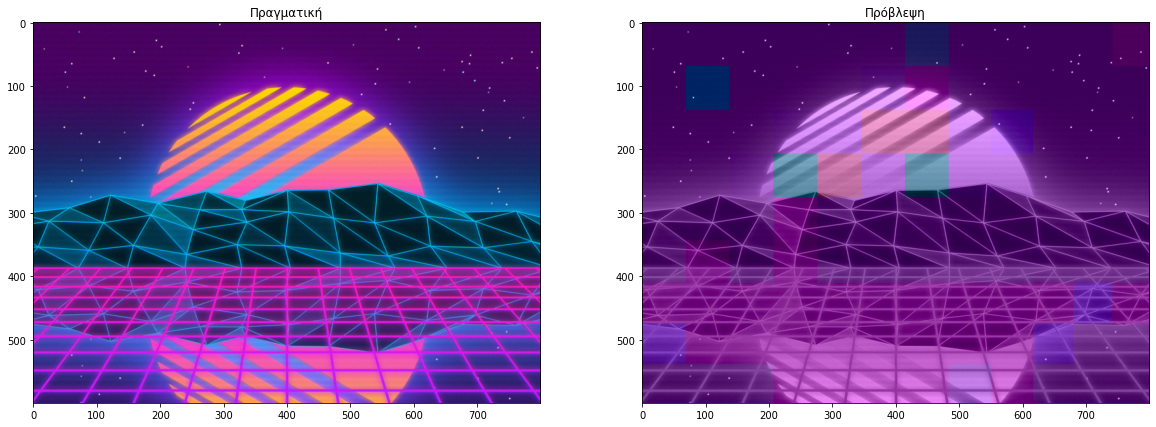

In [21]:
ab_centroids = centroids[:, 1:]

prediction = test_color_image(img_gray, ab_centroids, classifier, x_test, superpixels_gray)

helper.subplot_in_row_images(images = [img_rgb, prediction], titles = ["Πραγματική", "Πρόβλεψη"])